In [1]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [2]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.text import Tokenizer

from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

In [3]:
df = pd.read_csv('train.csv')

In [4]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
class_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


class_counts = df[class_columns].sum()


for class_name, count in class_counts.items():
    print(f'{class_name}: {count} örnek')

class_counts_df = pd.DataFrame(class_counts, columns=['Count'])
print(class_counts_df)

toxic: 15294 örnek
severe_toxic: 1595 örnek
obscene: 8449 örnek
threat: 478 örnek
insult: 7877 örnek
identity_hate: 1405 örnek
               Count
toxic          15294
severe_toxic    1595
obscene         8449
threat           478
insult          7877
identity_hate   1405


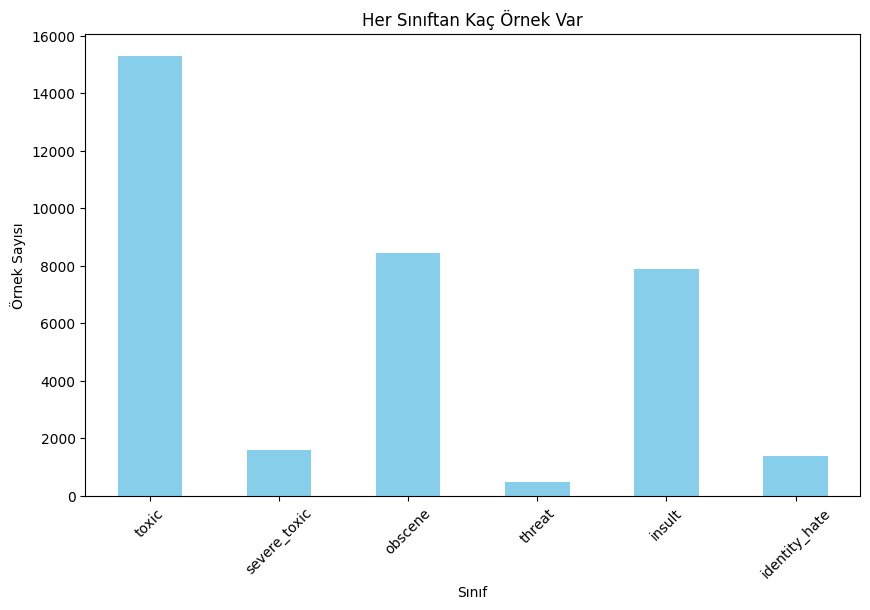

In [6]:
class_counts = df[class_columns].sum()


plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar', color='skyblue')
plt.title('Her Sınıftan Kaç Örnek Var')
plt.xlabel('Sınıf')
plt.ylabel('Örnek Sayısı')
plt.xticks(rotation=45)
plt.show()

# 1. Preprocessing

In [7]:
from tensorflow.keras.layers import TextVectorization

In [8]:
TextVectorization??

Init signature: TextVectorization(*args, **kwargs)
Source:        
@keras_export(
    "keras.layers.TextVectorization",
    "keras.layers.experimental.preprocessing.TextVectorization",
    v1=[],
)
class TextVectorization(base_preprocessing_layer.PreprocessingLayer):
    """A preprocessing layer which maps text features to integer sequences.

    This layer has basic options for managing text in a Keras model. It
    transforms a batch of strings (one example = one string) into either a list
    of token indices (one example = 1D tensor of integer token indices) or a
    dense representation (one example = 1D tensor of float values representing
    data about the example's tokens). This layer is meant to handle natural
    language inputs. To handle simple string inputs (categorical strings or
    pre-tokenized strings) see `tf.keras.layers.StringLookup`.

    The vocabulary for the layer must be either supplied on construction or
    learned via `adapt()`. When this layer is adapted, 

In [9]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [10]:
X

0         Explanation\nWhy the edits made under my usern...
1         D'aww! He matches this background colour I'm s...
2         Hey man, I'm really not trying to edit war. It...
3         "\nMore\nI can't make any real suggestions on ...
4         You, sir, are my hero. Any chance you remember...
                                ...                        
159566    ":::::And for the second time of asking, when ...
159567    You should be ashamed of yourself \n\nThat is ...
159568    Spitzer \n\nUmm, theres no actual article for ...
159569    And it looks like it was actually you who put ...
159570    "\nAnd ... I really don't think you understand...
Name: comment_text, Length: 159571, dtype: object

In [11]:
len(y)

159571

In [12]:
MAX_WORDS = 20000 # number of words in the vocab

In [13]:
vectorizer = TextVectorization(max_tokens=MAX_WORDS,
                               output_sequence_length=500,
                               output_mode='int')

In [14]:
vectorizer.adapt(X.values)

In [15]:
vectorized_text = vectorizer(X.values)

In [16]:
vectorized_text

<tf.Tensor: shape=(159571, 500), dtype=int64, numpy=
array([[ 643,   76,    2, ...,    0,    0,    0],
       [   1,   54, 2506, ...,    0,    0,    0],
       [ 425,  440,   70, ...,    0,    0,    0],
       ...,
       [   1, 7329,  383, ...,    0,    0,    0],
       [   5,   12,  533, ...,    0,    0,    0],
       [   5,    8,  130, ...,    0,    0,    0]], dtype=int64)>

In [17]:
#MCSHBAP - map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file

dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps bottlenecks

In [18]:

train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [19]:
len(train)

6981

# 2. Create Sequential Model

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, BatchNormalization,Flatten,GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [80]:
model = Sequential()
# Create the embedding layer 
model.add(Embedding(MAX_WORDS + 1, 128))  # Embedding boyutunu arttırdık
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(64, activation='tanh', return_sequences=True)))
model.add(Dropout(0.5))  # Dropout katmanı ekledik
model.add(GlobalMaxPooling1D())
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())  # Batch normalization katmanı ekledik
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))  # Dropout katmanı ekledik
model.add(Dense(128, activation='relu'))
# Final layer 
model.add(Dense(6, activation='sigmoid'))

In [90]:
model.compile(optimizer='Adam', loss='BinaryCrossentropy',metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 128)         2560128   
                                                                 
 bidirectional_2 (Bidirectio  (None, None, 128)        98816     
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, None, 128)         0         
                                                                 
 global_max_pooling1d_2 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_8 (Dense)             (None, 128)               16512     
                                                                 
 batch_normalization_2 (Batc  (None, 128)             

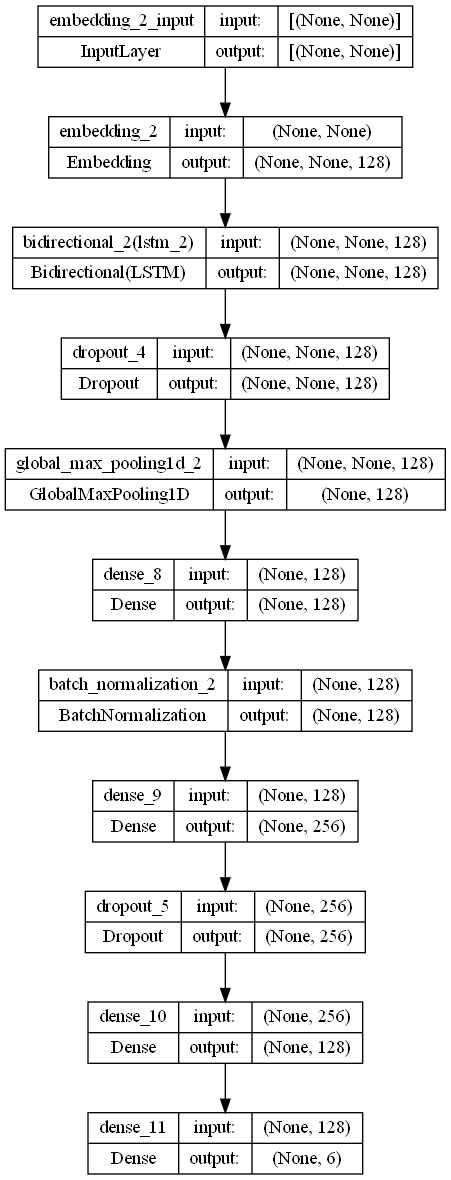

In [95]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_diagram.png', show_shapes=True, show_layer_names=True)

In [82]:
history = model.fit(train, epochs=10, validation_data=val, callbacks=[early_stopping])

Epoch 1/10
6981/6981 [==============================] - 587s 84ms/step - loss: 0.0658 - accuracy: 0.9571 - val_loss: 0.0572 - val_accuracy: 0.9939
Epoch 2/10
6981/6981 [==============================] - 580s 83ms/step - loss: 0.0517 - accuracy: 0.9601 - val_loss: 0.0587 - val_accuracy: 0.9939
Epoch 3/10
6981/6981 [==============================] - 587s 84ms/step - loss: 0.0462 - accuracy: 0.9687 - val_loss: 0.0457 - val_accuracy: 0.9945
Epoch 4/10
6981/6981 [==============================] - 583s 84ms/step - loss: 0.0428 - accuracy: 0.9619 - val_loss: 0.0467 - val_accuracy: 0.9945
Epoch 5/10
6981/6981 [==============================] - 584s 84ms/step - loss: 0.0400 - accuracy: 0.9681 - val_loss: 0.0461 - val_accuracy: 0.9924
Epoch 6/10
6981/6981 [==============================] - 593s 85ms/step - loss: 0.0374 - accuracy: 0.9702 - val_loss: 0.0547 - val_accuracy: 0.9938


In [109]:
from matplotlib import pyplot as plt

<Figure size 800x500 with 0 Axes>

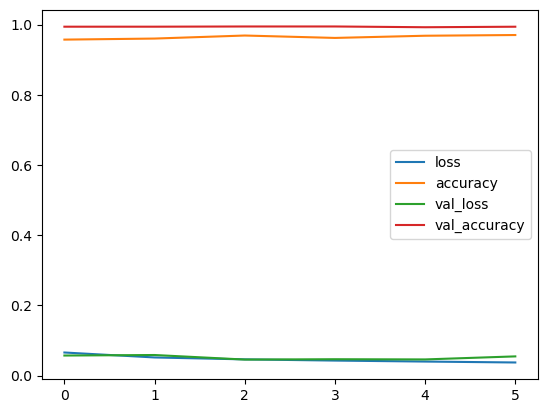

In [94]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

# 3. Make Predictions

In [26]:
input_text = vectorizer('You idiot I am going to punch you in the face. I am going to kill you.')

In [27]:
res = model.predict(np.expand_dims(input_text,0))

1/1 [==============================] - 0s 57ms/step


In [28]:
res

array([[0.7652855 , 0.24297799, 0.53754246, 0.23833239, 0.5028185 ,
        0.26667356]], dtype=float32)

1/1 [==============================] - 0s 57ms/step


In [118]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [31]:
(model.predict(batch_X) > 0.5).astype(int)

1/1 [==============================] - 0s 280ms/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [32]:
res.shape

(1, 6)

# 4. Evaluate Model

In [46]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy, Accuracy

In [87]:
pre = Precision()
re = Recall()
Cacc = CategoricalAccuracy()
acc = Accuracy()

In [88]:

for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    yhat=(yhat > 0.5).astype(int)
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)
    Cacc.update_state(y_true, yhat)

1/1 [==============================] - 0s 69ms/step


In [89]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()},Categorical_acc:{Cacc.result().numpy()}')

Precision: 0.9079457521438599, Recall:0.5337510704994202, Accuracy:0.9809114933013916,Categorical_acc:0.6359077095985413


# 5. Test and Gradio

In [5]:
import tensorflow as tf
import gradio as gr

C:\Users\taner\anaconda3\envs\py310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [83]:
model.save('toxicity4.h5')

In [21]:
model = tf.keras.models.load_model('toxicity4.h5')

In [23]:
input_str = vectorizer('hey i freaken hate you!')

In [24]:
res = model.predict(np.expand_dims(input_str,0))
res

1/1 [==============================] - 1s 1s/step


array([[0.32826632, 0.00296555, 0.084694  , 0.02189422, 0.12515055,
        0.03083863]], dtype=float32)

In [22]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)
    
    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)
    
    return text

In [32]:
import gradio as gr



interface = gr.Interface(fn=score_comment, 
                         inputs=gr.Textbox(lines=2, placeholder='Comment to score'),
                         outputs=gr.Textbox())

interface.launch(share=True)
#You idiot I am going to punch you in the face. I am going to kill you ni**er.
#I love his artstyle. He is one of the greatest artist in our era 

Running on local URL:  http://127.0.0.1:7860

Could not create share link. Missing file: c:\python\lib\site-packages\gradio\frpc_windows_amd64_v0.2. 

Please check your internet connection. This can happen if your antivirus software blocks the download of this file. You can install manually by following these steps: 

1. Download this file: https://cdn-media.huggingface.co/frpc-gradio-0.2/frpc_windows_amd64.exe
2. Rename the downloaded file to: frpc_windows_amd64_v0.2
3. Move the file to this location: c:\python\lib\site-packages\gradio


# Türkçe Dataset

In [ ]:
import pandas as pd
from googletrans import Translator
import time

df = pd.read_csv('train.csv')
df2 = pd.read_csv('train_tr.csv')
# subset_df = df2.iloc[25000:30000]
# print(subset_df)


translator = Translator()

column_to_translate = 'comment_text'

start_index = 43167
end_index = 43168

current_index = start_index

while current_index < end_index:

    translated_text = ""
    try:

        for index in range(current_index, end_index):
            row = df.iloc[index]
            for attempt in range(3):
                try:
                    translated_text = translator.translate(row[column_to_translate], src='en', dest='tr').text
                    break
                except Exception as e:
                    if attempt < 2:
                        time.sleep(2)
                    else:
                        raise e

            df2.at[index, "comment_text_tr"] = translated_text
            current_index = index + 1

        try:
            df2.to_csv('train_tr.csv', index=False)
            print(df2["comment_text_tr"])
        except Exception as e:
            print(e)
            raise e

        print("bitti")
        break
    except Exception as e:
        print(e)
        df2.to_csv('train_tr.csv', index=False, encoding='utf-8')
        time.sleep(5)

In [24]:
df_tr = pd.read_csv('train_tr.csv')

In [25]:
df_tr

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,Translated,comment_text_tr
0,0000997932d777bf,Explanation\nWhy were edits made under my user...,0,0,0,0,0,0,NaN,Açıklama\nKullanıcı adım altında yapılan düzen...
1,000103f0d9cfb60f,Wow! It looks like it matches this background ...,0,0,0,0,0,0,NaN,Vay! Takıldığım bu arka plan rengiyle eşleşiyo...
2,000113f07ec002fd,"Hey man, I'm not really trying to organize the...",0,0,0,0,0,0,NaN,"Hey dostum, aslında savaşı organize etmeye çal..."
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions for...",0,0,0,0,0,0,NaN,"""\nDaha\nİyileştirme konusunda gerçek bir öner..."
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,NaN,"Siz efendim, benim kahramanımsınız. Hangi sayf..."
...,...,...,...,...,...,...,...,...,...,...
43163,732eb36f953627c8,"""\n\nARROW. This may soon become a pertinent t...",0,0,0,0,0,0,NaN,"""\n\nOK. Giderek daha fazla öne çıkan Cumhuriy..."
43164,732eb439a8c8914b,Edwin van der Sar/Andres Palop\n\nRe: your edi...,0,0,0,0,0,0,NaN,Edwin van der Sar/Andres Palop\n\nYanıt: Edwin...
43165,732f6770e44bab6c,"""\n\nYes. I wasn't denying that that was a con...",0,0,0,0,0,0,NaN,"""\n\nEvet. Bunun bir sonuç olduğunu inkar etmi..."
43166,73361f2b04a885ff,Good work on the Bupropion page.,0,0,0,0,0,0,NaN,Bupropion sayfasında iyi çalışmalar.


In [26]:
class_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


class_counts = df_tr[class_columns].sum()


for class_name, count in class_counts.items():
    print(f'{class_name}: {count} örnek')

class_counts_df = pd.DataFrame(class_counts, columns=['Count'])
print(class_counts_df)

toxic: 4247 örnek
severe_toxic: 456 örnek
obscene: 2300 örnek
threat: 146 örnek
insult: 2152 örnek
identity_hate: 395 örnek
               Count
toxic           4247
severe_toxic     456
obscene         2300
threat           146
insult          2152
identity_hate    395


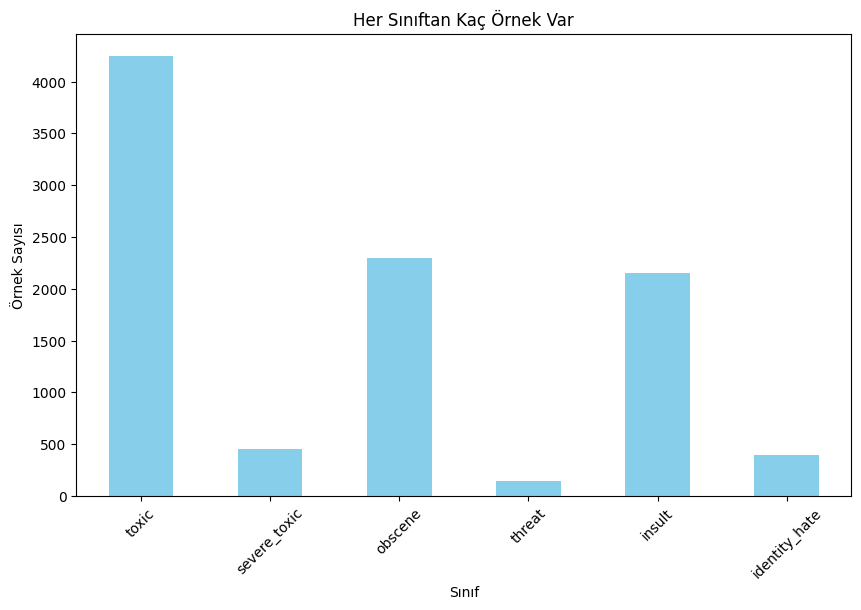

In [27]:
class_counts_tr = df_tr[class_columns].sum()


plt.figure(figsize=(10, 6))
class_counts_tr.plot(kind='bar', color='skyblue')
plt.title('Her Sınıftan Kaç Örnek Var')
plt.xlabel('Sınıf')
plt.ylabel('Örnek Sayısı')
plt.xticks(rotation=45)
plt.show()

In [28]:
X_tr = df_tr['comment_text_tr']
df_tr.drop('comment_text_tr', inplace=True,axis=1)
df_tr.drop('Translated', inplace=True,axis=1)
y_tr = df_tr[df_tr.columns[2:]].values

In [29]:
vectorizer_tr = TextVectorization(max_tokens=MAX_WORDS,
                               output_sequence_length=200,
                               output_mode='int')

In [30]:
#MCSHBAP - map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file
vectorizer_tr.adapt(X_tr.values)
vectorized_text_tr = vectorizer_tr(X_tr.values)
dataset_tr = tf.data.Dataset.from_tensor_slices((vectorized_text_tr, y_tr))
dataset_tr = dataset_tr.cache()
dataset_tr = dataset_tr.shuffle(160000)
dataset_tr = dataset_tr.batch(16)
dataset_tr = dataset_tr.prefetch(8) # helps bottlenecks
train_tr = dataset_tr.take(int(len(dataset_tr)*.7))
val_tr = dataset_tr.skip(int(len(dataset_tr)*.7)).take(int(len(dataset_tr)*.2))
test_tr = dataset_tr.skip(int(len(dataset_tr)*.9)).take(int(len(dataset_tr)*.1))

In [35]:
model_tr = Sequential()
# Create the embedding layer 
model_tr.add(Embedding(MAX_WORDS + 1, 128))  # Embedding boyutunu arttırdık
# Bidirectional LSTM Layer
model_tr.add(Bidirectional(LSTM(64, activation='tanh', return_sequences=True)))
model_tr.add(Dropout(0.5))  # Dropout katmanı ekledik
model_tr.add(GlobalMaxPooling1D())
# Feature extractor Fully connected layers
model_tr.add(Dense(128, activation='relu'))
model_tr.add(BatchNormalization())  # Batch normalization katmanı ekledik
model_tr.add(Dense(256, activation='relu'))
model_tr.add(Dropout(0.5))  # Dropout katmanı ekledik
model_tr.add(Dense(128, activation='relu'))
# Final layer 
model_tr.add(Dense(6, activation='sigmoid'))

In [36]:
model_tr.compile(optimizer='Adam', loss='BinaryCrossentropy',metrics=['accuracy'])
early_stopping_tr = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_tr.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 128)         2560128   
                                                                 
 bidirectional_1 (Bidirectio  (None, None, 128)        98816     
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, None, 128)         0         
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 batch_normalization_1 (Batc  (None, 128)             

In [37]:
y_tr

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]], dtype=int64)

In [38]:
history_tr = model_tr.fit(train_tr, epochs=10, validation_data=val_tr, callbacks=[early_stopping_tr])

Epoch 1/10
1888/1888 [==============================] - 78s 39ms/step - loss: 0.0988 - accuracy: 0.8900 - val_loss: 0.0897 - val_accuracy: 0.9950
Epoch 2/10
1888/1888 [==============================] - 72s 38ms/step - loss: 0.0673 - accuracy: 0.8897 - val_loss: 0.0712 - val_accuracy: 0.9942
Epoch 3/10
1888/1888 [==============================] - 74s 39ms/step - loss: 0.0578 - accuracy: 0.9247 - val_loss: 0.0827 - val_accuracy: 0.9943
Epoch 4/10
1888/1888 [==============================] - 74s 39ms/step - loss: 0.0537 - accuracy: 0.9325 - val_loss: 0.0629 - val_accuracy: 0.9893
Epoch 5/10
1888/1888 [==============================] - 76s 40ms/step - loss: 0.0493 - accuracy: 0.9170 - val_loss: 0.0613 - val_accuracy: 0.9951
Epoch 6/10
1888/1888 [==============================] - 80s 43ms/step - loss: 0.0439 - accuracy: 0.8879 - val_loss: 0.0575 - val_accuracy: 0.9937
Epoch 7/10
1888/1888 [==============================] - 73s 39ms/step - loss: 0.0414 - accuracy: 0.8153 - val_loss: 0.0575 -

<Figure size 800x500 with 0 Axes>

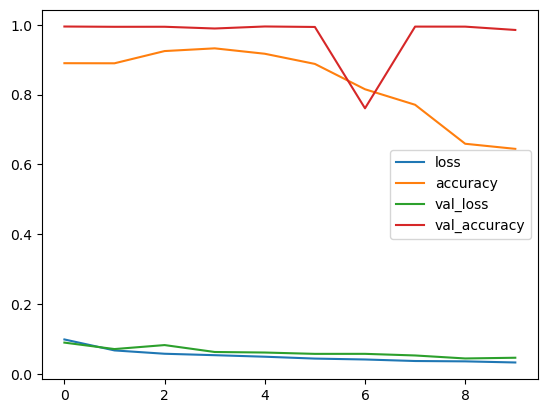

In [98]:
plt.figure(figsize=(8,5))
pd.DataFrame(history_tr.history).plot()
plt.show()

In [48]:
pre_tr = Precision()
re_tr = Recall()
Cacc_tr = CategoricalAccuracy()
acc_tr = Accuracy()
for batch in test_tr.as_numpy_iterator(): 
    # Unpack the batch 
    X_true, y_true = batch
    # Make a prediction 
    yhat = model_tr.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    yhat=(yhat > 0.5).astype(int)
    
    pre_tr.update_state(y_true, yhat)
    re_tr.update_state(y_true, yhat)
    acc_tr.update_state(y_true, yhat)
    Cacc_tr.update_state(y_true, yhat)


1/1 [==============================] - 0s 33ms/step


In [49]:
print(f'Precision: {pre_tr.result().numpy()}, Recall:{re_tr.result().numpy()}, Accuracy:{acc_tr.result().numpy()},Categorical_acc:{Cacc_tr.result().numpy()}')

Precision: 0.8473557829856873, Recall:0.8323494791984558, Accuracy:0.9895833134651184,Categorical_acc:0.8475836515426636


In [31]:
def score_comment_tr(comment):
    vectorized_comment = vectorizer_tr([comment])
    results = model_tr.predict(vectorized_comment)
    
    text = ''
    for idx, col in enumerate(df_tr.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)
    
    return text

In [50]:
model_tr.save('toxicity3_tr.h5')

In [23]:
model_tr = tf.keras.models.load_model('toxicity3_tr.h5')

In [33]:
import gradio as gr



interface = gr.Interface(fn=score_comment_tr, 
                         inputs=gr.Textbox(lines=2, placeholder='Comment to score'),
                         outputs=gr.Textbox())

interface.launch(share=True)
#Bu adamı gerçekten çok seviyorum. Benim için çok büyük bir ilham kaynağı
# Sen aptalsın. Senin yüzüne yumruk atacağım. Seni öldüreceğim.

Running on local URL:  http://127.0.0.1:7861

Could not create share link. Missing file: c:\python\lib\site-packages\gradio\frpc_windows_amd64_v0.2. 

Please check your internet connection. This can happen if your antivirus software blocks the download of this file. You can install manually by following these steps: 

1. Download this file: https://cdn-media.huggingface.co/frpc-gradio-0.2/frpc_windows_amd64.exe
2. Rename the downloaded file to: frpc_windows_amd64_v0.2
3. Move the file to this location: c:\python\lib\site-packages\gradio


1/1 [==============================] - 0s 28ms/step


In [64]:
input_str = vectorizer_tr('Sen berbatsın! Sana vuracağım.')
res = model_tr.predict(np.expand_dims(input_str,0))
res

1/1 [==============================] - 0s 46ms/step


array([[0.97272   , 0.0459734 , 0.9399486 , 0.00395432, 0.73234683,
        0.02765113]], dtype=float32)